In [1]:
# PyTorch imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as T
from torchvision.transforms import ToTensor
import torch.nn.functional as F
# other imports
import numpy as np
import math
import h5py
import matplotlib.pyplot as plt
import scipy

## **01: Load data**

In [2]:
# Class: h5py_Dataset
# Reference: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
"""partition: dictionary of {set of IDs} for train, partition, validation"""
"""labels: dictionary, contain index of labels y, given index of input X"""
"""Dataset class, derived from: PyTorch's Dataset"""
def Load_h5py(DATA):
    # load data
    with h5py.File(DATA, 'r') as hdf:
        keys = list(hdf.keys())
        trnOrg = hdf.get('trnOrg')
        x_GroundTruth = np.array(trnOrg) # <- this is our y
        trnMask = hdf.get('trnMask')
        P_SamplingOperator = np.array(trnMask)
    # Formula: y = P*Fourier(x) + e <- e = 0 here!
    y_NoisyMeasurement = P_SamplingOperator * np.fft.fft2(x_GroundTruth) + 0
    # Formula: x_hat = InverseFourier(y)
    x_hat_ZeroFilledImg = np.fft.ifft2(y_NoisyMeasurement) # <- this is our X
    return x_hat_ZeroFilledImg, x_GroundTruth

class h5py_Dataset(torch.utils.data.Dataset):
    # initialize:
    def __init__(self, subset_X_IDs, y_IDs, DATA):
        # subset_X_IDs: e.g. only use mth to nth examples to train
        self.subset_X_IDs = subset_X_IDs
        self.y_IDs = y_IDs
        self.X, self.y = Load_h5py(DATA=DATA)
    # length: number of elements in subset of X_IDs
    def __len__(self):
        return len(self.subset_X_IDs)
    # get item by index in [m, n]
    def __getitem__(self, index):
        ID = self.subset_X_IDs[index]
        # pick out X & y
        X_pick = self.X[ID]
        y_pick = self.y[ID]
        return Complex_to_2_Channel(X_pick), Complex_to_2_Channel(y_pick)
    
def Complex_to_2_Channel(image):
    # image = 2d numpy array, shape = (m, n) <- 1 channel
    real = image.real
    imag = image.imag
    comb = np.dstack([real, imag]) # <- shape = (m, n, 2) <- 2 channel
    comb_t = ToTensor()(comb) # <- shape (2, m, n) <- 2 channel, reformat to Tensor
    return comb_t

torch.float64


Text(0.5, 1.0, 'a testing data sample: torch.Size([2, 256, 232])')

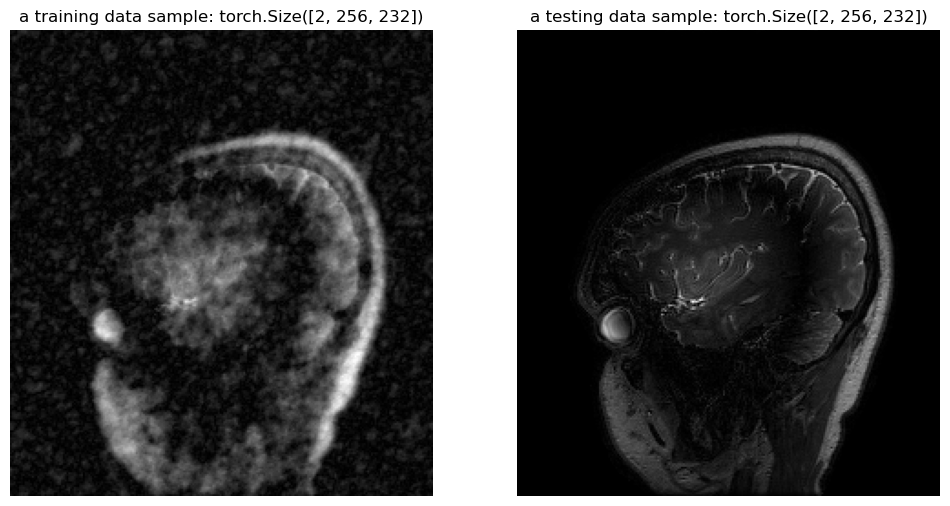

In [23]:
# partition data
training_ct = 294
dev_ct = 32
partition = {
    'train': list(range(dev_ct)),
    'validate': list(range(294, 300)),
    'test': list(range(300, 360))
}
labels = list[range(0, 360)]
# I put dataset dataset.hdf5 in folder 'my_data'
train_dataset = h5py_Dataset(subset_X_IDs=partition['train'],
                            y_IDs=labels,
                            DATA="my_data/dataset.hdf5")
test_dataset = h5py_Dataset(subset_X_IDs=partition['test'],
                            y_IDs=labels,
                            DATA="my_data/dataset.hdf5")
# Testing 'h5py_Dataset' class
fig = plt.figure(figsize=(12, 12))
rows = 1
columns = 2
x1, y1 = train_dataset.__getitem__(1)
print(x1.dtype)
# to show images, I use absolute value
fig.add_subplot(rows, columns, 1)
plt.imshow(np.sqrt(x1[0]**2 + x1[0]**2), cmap = 'gray')
plt.axis('off')
plt.title("a training data sample: " + str(x1.shape))
# for each pixel a + bi, I show sqrt(a**2 + b**2)
fig.add_subplot(rows, columns, 2)
plt.imshow(np.sqrt(y1[0]**2 + y1[0]**2), cmap = 'gray')
plt.axis('off')
plt.title("a testing data sample: " + str(y1.shape))

Text(0.5, 1.0, 'reshaped by CenterCrop: torch.Size([2, 256, 256])')

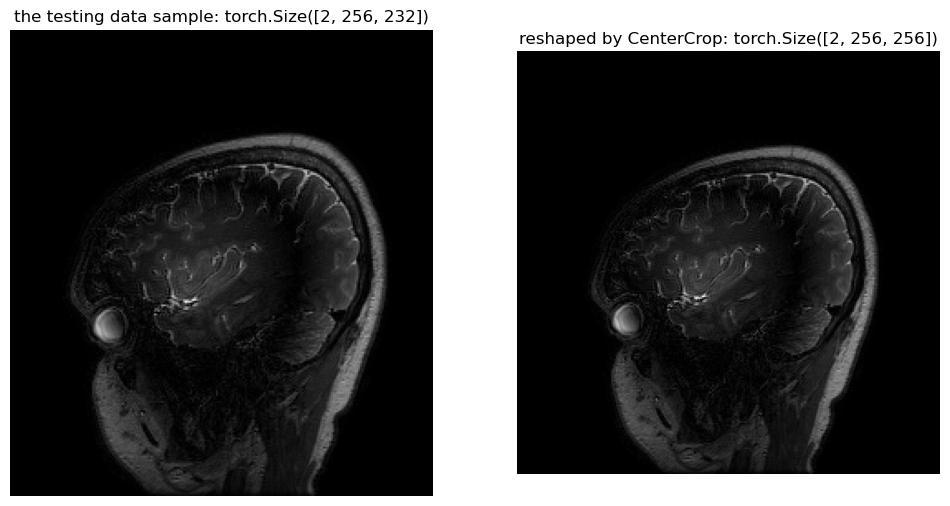

In [4]:
fig2 = plt.figure(figsize=(12, 12))
rows = 1
columns = 2
y1_resize = T.CenterCrop(size=(256, 256))(y1)

fig2.add_subplot(rows, columns, 1)
plt.imshow(np.sqrt(y1[0]**2 + y1[0]**2), cmap = 'gray')
plt.axis('off')
plt.title("the testing data sample: " + str(y1.shape))

fig2.add_subplot(rows, columns, 2)
plt.imshow(np.sqrt(y1_resize[0]**2 + y1_resize[0]**2), cmap = 'gray')
plt.axis('off')
plt.title("reshaped by CenterCrop: " + str(y1_resize.shape))

In [5]:
batch_size = 1

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
for X, y in test_dataloader:
    print(f"Shape of X, an image [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y, also an image: {y.shape} {y.dtype}")
    break

Shape of X, an image [N, C, H, W]: torch.Size([1, 2, 256, 232]) torch.float32
Shape of y, also an image: torch.Size([1, 2, 256, 232]) torch.float32


## **02: Setup**

In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [32]:
# train()
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.to(torch.double), y.to(torch.double))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
# test()
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
# Encapsulated: two convolutions, each followed by ReLU
class Conv3x3_Relu_2x(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.go = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0, stride=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.go(x)

class Contract(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.go = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        )
    def forward(self, x):
        return self.go(x)
class Expand(nn.Module):
    def __init__(self, in_channels, out_channels, kernel):
        super().__init__()
        # Reference: https://github.com/pytorch/vision/issues/1708
        self.go = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            # upsampling: just operator, NO param
            # convTransPose: has param, can train
            nn.ConvTranspose2d(out_channels, int(out_channels/2), 
                               kernel_size=(kernel,kernel), stride=2, padding=0)
        )
    def forward(self, x):
        return self.go(x)

In [ ]:
# The Neural Network
# Reference:
# https://arxiv.org/pdf/1505.04597.pdf
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
class Me_Net(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(Me_Net, self).__init__()
        # n_channels = 2 for MRI image (real & complex part for ea pixel)
        # n_classes: probability distribution for ea pixel. =2 for MRI image
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.CN1 = (Conv3x3_Relu_2x(n_channels, 64))
        # followed by 2x2 max pooling, stride = 2, for downsampling
        self.D1 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        self.CN2 = (Conv3x3_Relu_2x(64, 128))
        self.D2 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        self.CN3 = (Conv3x3_Relu_2x(128, 256))
        self.D3 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        self.CN4 = (Conv3x3_Relu_2x(256, 512))
        self.D4 = nn.MaxPool2d(kernel_size=3, stride=1, padding=0) # mod
        self.BOTM = (Conv3x3_Relu_2x(512, 1024))
        # Reference: https://github.com/pytorch/vision/issues/1708
        self.U1 = nn.ConvTranspose2d(1024, 512, kernel_size=(10,10), stride=2, padding=0)
        self.EP1 = (Conv3x3_Relu_2x(1024, 512))
        self.U2 = nn.ConvTranspose2d(512, 256, kernel_size=(18,18), stride=2, padding=0)
        self.EP2 = (Conv3x3_Relu_2x(512, 256))
        self.U3 = nn.ConvTranspose2d(256, 128, kernel_size=(18,18), stride=2, padding=0)
        self.EP3 = (Conv3x3_Relu_2x(256, 128))
        self.U4 = nn.ConvTranspose2d(128, 64, kernel_size=(26,26), stride=2, padding=0)
        self.EP4 = (Conv3x3_Relu_2x(128, 64))
        self.out = nn.Conv2d(in_channels=64, out_channels=n_classes, kernel_size=(1, 1), stride=1)
    def forward(self, input):
        # going down
        CN1 = self.CN1(input) # take 1/2 to concatenate
        # print(f"shape of CN1: {CN1.shape}")
        D1 = self.D1(CN1)
        CN2 = self.CN2(D1) # take 1/2 to concatenate
        # print(f"shape of CN2: {CN2.shape}")
        D2 = self.D2(CN2)
        CN3 = self.CN3(D2) # take 1/2 to concatenate
        # print(f"shape of CN3: {CN3.shape}")
        D3 = self.D4(CN3)
        CN4 = self.CN4(D3) # take 1/2 to concatenate
        # print(f"shape of CN4: {CN4.shape}")
        D4 = self.D4(CN4)
        # hit bottom
        BOTM = self.BOTM(D4)
        # print(f"bottom: {BOTM.shape}")
        # going up
        U1 = self.U1(BOTM) # need other 1/2
        # print(f"shape of U1: {U1.shape}")
        temp = T.CenterCrop(size=(CN4.shape[2], CN4.shape[3]))(U1)
        # print(f"shape of temp: {temp.shape}")
        combine = torch.cat([temp, CN4], dim=1)
        # print(f"shape of combine: {combine.shape}")
        EP1 = self.EP1(combine) 
        # U1 too big with mod, so we crop U1!
        U2 = self.U2(EP1) # need other 1/2
        # print(f"shape of U2: {U2.shape}")
        EP2 = self.EP2(torch.cat([T.CenterCrop(size=(CN3.shape[2], CN3.shape[3]))(U2), CN3], dim=1))
        U3 = self.U3(EP2) # need other 1/2
        # print(f"shape of U3: {U3.shape}")
        EP3 = self.EP3(torch.cat([T.CenterCrop(size=(CN2.shape[2], CN2.shape[3]))(U3), CN2], dim=1))
        U4 = self.U4(EP3) # need other 1/2
        # print(f"shape of U4: {U4.shape}")
        EP4 = self.EP4(torch.cat([T.CenterCrop(size=(CN1.shape[2], CN1.shape[3]))(U4), CN1], dim=1))
        logits = self.out(EP4)
        # print(f"shape of raw output: {logits.shape}")
        logits_cropped = T.CenterCrop(size=(input.shape[2], input.shape[3]))(logits)
        # print(f"shape of cropped output: {logits_cropped.shape}")
        return logits_cropped.to(torch.double)
    
model = Me_Net(n_channels=2,n_classes=2).to(device).to(torch.double)
# print(model)

# Optimization
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Error I got: RuntimeError: Input type (double) and bias type (float) should be the same
>Problem: when training, I wrote:
>>train(train_dataloader, model.to, loss_fn, optimizer)

>Solution: train(train_dataloader, model.to(torch.float64), loss_fn, optimizer)

In [ ]:
model.eval()
x, y = test_dataset[0][0], test_dataset[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]